# COMP 534 - Applied Artificial Intelligence
## CA2 - Neural network regression
This notebook was produced as a deliverable for a group project for the above module, as part of the 2021-2022 Data Science and Artificial Intelligence MSc course at the University of Liverpool. It contains the design and optimisation of a neural network to solve a regression problem.
### Preparation
#### Setup
Import required libraries, tools and classifiers.

In [49]:
# Scikeras wrapper requires installation on colab
pip install scikeras

In [50]:
# Data handling mathematical tools
import numpy as np
import pandas as pd

# Creating plots
import matplotlib.pyplot as plt
import seaborn as sns

# Monitor training progress
from time import perf_counter

# Data splitting and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Hyperparameter optimisation
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Hyperparameter search
from sklearn.model_selection import GridSearchCV
# Performance evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from tensorflow import keras

# Neural network
# NN wrapper for ease of handling
from scikeras.wrappers import KerasRegressor
# NN structure
from keras.models import Sequential
from keras.layers import Dense
# NN optimisers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
# Early stopping
from keras.callbacks import EarlyStopping

# Reduce tensorflow verbosity
from tensorflow import get_logger
get_logger().setLevel('ERROR')

# Set random seeds for reproducibility
np.random.seed(123)
from tensorflow.random import set_seed
set_seed(123)

# Check connected to GPU
from tensorflow.test import gpu_device_name
device_name = gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#### Data
This analysis uses a dataset consisting of house sales in King County, USA. The aim is to predict sale price based on the available features. The dataset is available for download on Kaggle.  
https://www.kaggle.com/datasets/harlfoxem/housesalesprediction (last accessed 30/03/22)

In [31]:
from google.colab import files
files.upload()

Saving kc_house_data.csv to kc_house_data (1).csv


{'kc_house_data.csv': b'id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15\n"7129300520","20141013T000000",221900,3,1,1180,5650,"1",0,0,3,7,1180,0,1955,0,"98178",47.5112,-122.257,1340,5650\n"6414100192","20141209T000000",538000,3,2.25,2570,7242,"2",0,0,3,7,2170,400,1951,1991,"98125",47.721,-122.319,1690,7639\n"5631500400","20150225T000000",180000,2,1,770,10000,"1",0,0,3,6,770,0,1933,0,"98028",47.7379,-122.233,2720,8062\n"2487200875","20141209T000000",604000,4,3,1960,5000,"1",0,0,5,7,1050,910,1965,0,"98136",47.5208,-122.393,1360,5000\n"1954400510","20150218T000000",510000,3,2,1680,8080,"1",0,0,3,8,1680,0,1987,0,"98074",47.6168,-122.045,1800,7503\n"7237550310","20140512T000000",1.225e+006,4,4.5,5420,101930,"1",0,0,3,11,3890,1530,2001,0,"98053",47.6561,-122.005,4760,101930\n"1321400060","20140627T000000",257500,3,2.25,1715,6819,"2",0,0,3,7,1715,0,1995,0,"98003

In [32]:
df = pd.read_csv('kc_house_data.csv')

Show distribution of features:

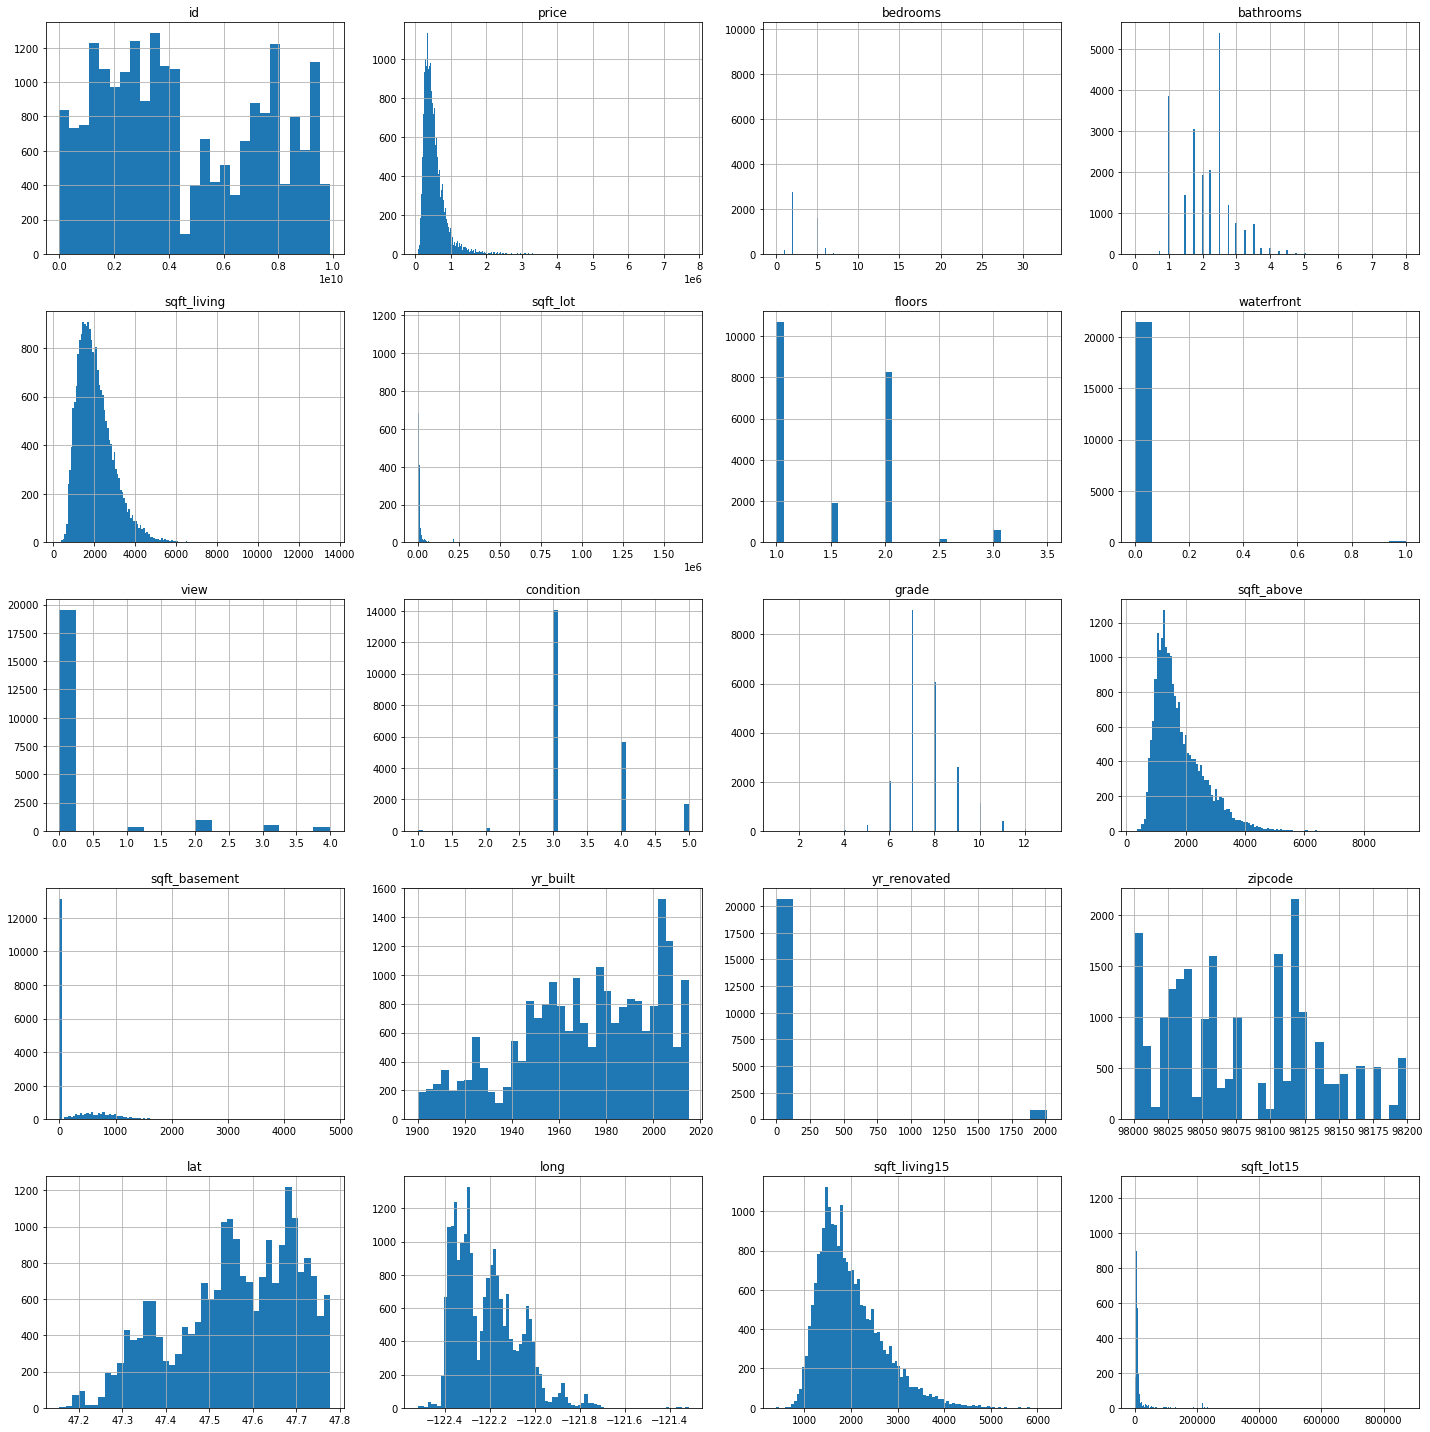

In [33]:
df.hist(figsize=(20,20), bins='auto')
plt.tight_layout()

#### Cleaning
Several cleaning steps are required before the dataset can be used to train a neural network.
##### Remove outliers
Several features have very large outliers which reduce model performance. These are removed.

In [34]:
originalRowCount = df.shape[0]
# Drop rows according to various conditions
df = df[(df['bedrooms'] > 0) & (df['bedrooms'] < 12)]
df = df[(df['bathrooms'] > 0) & (df['bathrooms'] < 12)]
df = df[df['sqft_lot'] < 5e5]
df = df[df['sqft_lot15'] < 3.5e5]
# Summary of impact on dataset
print(f'{((originalRowCount - df.shape[0])*100 / originalRowCount):.2f}% of rows removed')

0.22% of rows removed


##### Date
Date of sale can be used by turning it into a numerical variable.

In [35]:
# Cast date as datetime type
df['date'] = pd.to_datetime(df['date'])
# Create numerical variable as: difference between latest date in dataset and each other sale date
df['daysSinceSale'] = (df['date'].max() - df['date']).dt.days

##### Binning
The two features below contain mostly 0s and a small number of records with other values. The 0 values are still valid (no basement and never renovated) but could negatively impact performance. As a result this features will both be binned.

In [36]:
# Evenly bin all non 0 values and assign labels 1 - 10
bins = 9
df['basementOrdinal'] = pd.cut(df[df['sqft_basement']>0]['sqft_basement'], bins, labels=range(1, bins+1)).astype(int)
# Assign label of 0 to 0 values
df['basementOrdinal'] = df['basementOrdinal'].fillna(0)

In [37]:
# Evenly bin all non 0 values and assign labels 1 - 10
bins = 9
df['renovatedOrdinal'] = pd.cut(df[df['yr_renovated']>0]['yr_renovated'], bins, labels=range(1, bins+1)).astype(int)
# Assign label of 0 to 0 values
df['renovatedOrdinal'] = df['renovatedOrdinal'].fillna(0)

##### Transform skewed features
Several features are right skewed. These are natural log transformed to bring in the outliers and reduce their impact of model performance.

In [38]:
# List to hold skewed feature names
skewedVariables = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']
# List to hold new feature names
logVariables = ['priceLog', 'sqft_livingLog', 'sqft_lotLog', 'sqft_aboveLog', 'sqft_living15Log', 'sqft_lot15Log']
# Create new transformed features
df[logVariables] = np.log(df[skewedVariables])

##### Drop unused columns
Any remaining unused or superfluous columns are now removed.

In [39]:
# Drop original skewed features
df = df.drop(columns=skewedVariables)
# Drop features which have been replaced, along with id and zipcode
df = df.drop(columns=['date', 'id', 'sqft_basement', 'yr_renovated', 'zipcode',])

##### Move target price feature
Target variable moved to help when splitting it away from features.

In [40]:
# Remove target variable
feature = df.pop('priceLog')
# Reinsert at index 0
df.insert(0, 'priceLog', feature)

#### Splitting
The dataset is now ready to be split for use with the model. The features and target variable are separated.

In [41]:
# Create numpy array from pandas dataframe
data = df.values
# Create array of features
X = data[:, 1:]
# Create target array
y = data[:, 0].reshape(-1, 1)

Features and target variable are split into training and test set.

In [42]:
# 80% train and 20% test
# Data shuffled to reduce any bias in the order of the dataset
# Define random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=123,
                                                   )

There is a broad range of features across different scales. Some are normally distributed and others are binned labels. The features are normalised to account for this variation.

In [43]:
# Create min max scaler for features
featureScaler = MinMaxScaler()
# Fit to training data
featureScaler.fit(X_train)
# Normalise train and test features
X_train = featureScaler.transform(X_train)
X_test = featureScaler.transform(X_test)

Having been natural log transformed, the target variable is now normally distributed. This will be standardised to reduce the spread of values.

In [44]:
# Create standard scaler for target
targetScaler = StandardScaler()
# Fit to training data
targetScaler.fit(y_train)
# Standardise train and test target variable
y_train = targetScaler.transform(y_train)
y_test = targetScaler.transform(y_test)

Once predictions have been made using a model, it will be necessary to revert the predictions and target variable test values back to their original scale in order for informed conclusions to be drawn regarding model performance.

In [45]:
# Function to invert target variable (predicted or true values) to original form and reshape to 1 dimension for plotting
def targetReverter(data):
    return np.exp(targetScaler.inverse_transform(data).reshape(data.shape[0]))

### Model optimisation
#### Choice of loss function
The first hyperparameter that will be considered is the loss function. This is due to the fact that it will then be used as a key measure throughout the rest of the analysis. The two loss functions investigated here are mean squared error and mean absolute error. A relatively simple neural network will be used to produce results for comparison.

In [19]:
# NN with 2 hidden layers to compare loss functions
def lossModel(loss):
    # 2 hidden layers, 8 nodes each, relu activation function
    model = Sequential()
    model.add(Dense(units=8, input_shape=(18,),  activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    # Input loss function and SGD optimiser
    model.compile(loss=loss, optimizer='SGD')
    return model

The training set is further split to provide a validation set for evaluation of this hyperparameter.

In [ ]:
# 80% train and 20% validate
# Data shuffled to reduce any bias in the order of the dataset
# Define random state for reproducibility
X_trainLoss, X_validateLoss, y_trainLoss, y_validateLoss = train_test_split(X_train,
                                                                            y_train,
                                                                            test_size=0.20,
                                                                            shuffle=True,
                                                                            random_state=123
                                                                           )

Two models are created, identical except for selected loss function. These undergo the same training process and are then used to make predictions on the validation data.

In [ ]:
# Create models using selected loss functions
modelMSE = lossModel('mean_squared_error')
modelMAE = lossModel('mean_absolute_error')
# Store names for naming results
names = ['MSE', 'MAE']
# Dictionary to store predictions
predDict = {}
# Iterate over both models
for i, model in enumerate([modelMSE, modelMAE]):
    # Fit model to training data
    model.fit(X_trainLoss,
              y_trainLoss,
              epochs=100,
              batch_size=32,
              verbose=0,
             )
    # Use trained model to make prediction on validation data
    y_validateLossPred = model.predict(X_validateLoss)
    # Store predictions
    predDict[names[i]] = y_validateLossPred    

Because the hyperparameter that we are optimising is itself the error measurement used to train the model, in order to make a valid comparison it is most informative to compare predicted and true values in real terms using their original scale.

In [ ]:
# Revert predictions and true values to original scale
revertPredMSE = targetReverter(predDict['MSE'])
revertPredMAE = targetReverter(predDict['MAE'])
revertValid = targetReverter(y_validateLoss)

Plotting predictions against true values provides a visual comparison of models' performance. A perfect model would produce points along the line x=y.

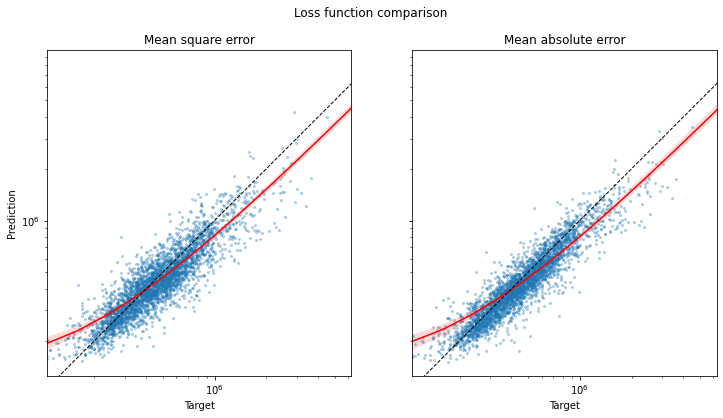

In [ ]:
# Create figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)

# MSE plot
sns.regplot(ax=axs[0],
            x=revertValid,
            y=revertPredMSE,
            scatter_kws={
                's':4,
                'alpha':0.3
            },
            line_kws={
                'linewidth':1.5,
                'color':'red'
            }
           )
# Plot line of x=y for comparison
xpoints0 = ypoints0 = axs[0].get_xlim()
axs[0].plot(xpoints0, ypoints0, linestyle='--', color='k', lw=1)
axs[0].axis('equal')
# Set title, label axes and log scales 
axs[0].set_title('Mean square error')
axs[0].set(xscale='log', yscale='log')
axs[0].set_xlabel('Target')
axs[0].set_ylabel('Prediction')

# MAE plot
sns.regplot(ax=axs[1],
            x=revertValid,
            y=revertPredMAE,
            scatter_kws={
                's':4,
                'alpha':0.3,                
            },
            line_kws={
                'linewidth':1.5,
                'color':'red'
            }
           )
# Plot line of x=y for comparison
xpoints1 = ypoints1 = axs[1].get_xlim()
axs[1].plot(xpoints1, ypoints1, linestyle='--', color='k', lw=1)
axs[1].axis('equal')
# Set title, label axes and log scales 
axs[1].set_title('Mean absolute error')
axs[1].set(xscale='log', yscale='log')
axs[1].set_xlabel('Target')

# Add title
fig.suptitle('Loss function comparison', fontsize=12)
#fig.savefig('lossFunctionComparison', bbox_inches='tight')
plt.show()

Log axes are used to bring in the outliers and show the majority of the points more clearly. Results for both loss functions are similar, however we can see that there is less divergence from the x=y line in the MAE plot.

In [ ]:
print(f'MSE when using mean squared error loss: {mean_squared_error(revertValid, revertPredMSE, squared=False):.2f}')
print(f'MSE when using mean absolute error loss: {mean_squared_error(revertValid, revertPredMAE, squared=False):.2f}\n')
print(f'MAE when using mean squared error loss: {mean_absolute_error(revertValid, revertPredMSE):.2f}')
print(f'MAE when using mean absolute loss: {mean_absolute_error(revertValid, revertPredMAE):.2f}')

MSE when using mean squared error loss: 184801.27
MSE when using mean absolute error loss: 174072.10

MAE when using mean squared error loss: 103784.60
MAE when using mean absolute loss: 86665.35


The MAE achieves a lower error using both error measurements. MSE typically penalises outliers more than MAE and due to taking the natural log transformat of the skewed features, this impact may have been negated during data preparation.
#### Grid search optimisation: learning rate, batch size and optimiser
An exhaustive grid search will be performed to identify suitable values for these hyperparameters.

In [67]:
# Define search space
searchSpace = {
    'optimizer':[SGD, RMSprop, Adam], # SGD slow but kept for comparison
    'optimizer__learning_rate': [0.1, 0.01], # 0.001 removed, too slow training time
    'batch_size':[32, 64, 128],
}

Define neural network for use with the grid search.

In [47]:
# NN with 2 hidden layers
def gridSearchModel():
    # 2 hidden layers, 8 nodes each, relu activation function
    model = Sequential()
    model.add(Dense(units=8, input_shape=(18,),  activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    return model

##### Early stopping
To limit training time during the grid search, early stopping will be implemented, ending training when no improvement in the loss function is observed after a number of updates.

In [68]:
# Define early stopping, patience is number of consecutive updates which must show no improvement for early stopping to occur
earlyStop = EarlyStopping(monitor='loss', mode='min', verbose=2, patience=5)
# Use scikeras wrapper for compatibility with grid search
wrappedGridSearchModel = KerasRegressor(model=gridSearchModel,
                                        loss=keras.losses.mean_squared_error,
                                        epochs=1000,
                                        verbose=0,
                                        callbacks=[earlyStop],
                                       )
# Define cross validation
kfold = KFold(n_splits=2)
# Create search, score each by MSE
hyperparameterSearch = GridSearchCV(wrappedGridSearchModel,
                                    searchSpace,
                                    scoring='neg_mean_squared_error',
                                    cv=kfold,
                                    verbose=2,
                                    )
# Perform search over searchSpace
searchResult = hyperparameterSearch.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Epoch 34: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.1; total time=  23.1s
Epoch 30: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.1; total time=  21.3s
Epoch 168: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.01; total time= 2.4min
Epoch 91: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.01; total time= 1.4min
Epoch 8: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.rmsprop.RMSprop'>, optimizer__learning_rate=0.1; total time=   6.9s
Epoch 23: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.rmsprop.RMSprop'>, optimizer__learning_rate=0.1; total time= 

In [69]:
# Store best parameters found
optimumParameters = searchResult.best_params_
print(optimumParameters)
# Store all results in new dataframe
results = pd.DataFrame(searchResult.cv_results_)

{'batch_size': 64, 'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'optimizer__learning_rate': 0.01}


In [72]:
# Create long form of results for plotting
resultsLong = pd.melt(results,
                      id_vars=['param_batch_size', 'param_optimizer', 'param_optimizer__learning_rate'],
                      var_name='splitNumber',
                      value_name='MSE',
                      value_vars=['split0_test_score', 'split1_test_score',])# 'split2_test_score'])
# Create new column with optimiser name for labels
resultsLong['optimiser'] = resultsLong['param_optimizer'].apply(lambda x: x.__name__)
# Rename learning rate column
resultsLong = resultsLong.rename(columns={'param_optimizer__learning_rate':'learningRate'})

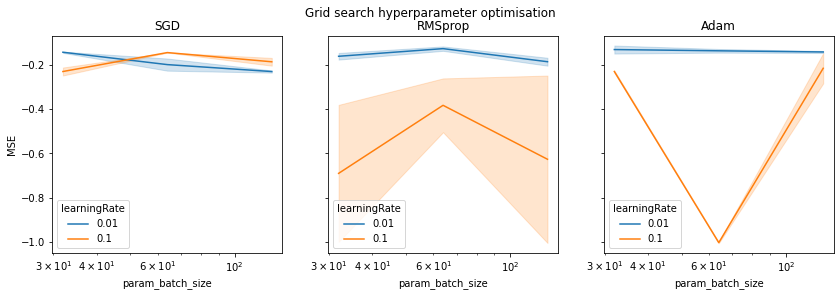

In [74]:
# Create figure for grid search results
fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True)
# Plot results
for i, ax in enumerate(axs):
    sns.lineplot(ax=ax,
                data=resultsLong[resultsLong['optimiser'] == resultsLong['optimiser'].unique()[i]],
                x='param_batch_size',
                y='MSE',
                hue='learningRate',
                palette='tab10',
                )    
    # Set log axis and title
    ax.set(xscale='log')
    ax.set_title(resultsLong['optimiser'].unique()[i])
# Add title
fig.suptitle('Grid search hyperparameter optimisation', fontsize=12)
#fig.savefig('gridSearchResults', bbox_inches='tight')
plt.show()

some words
#### Neural network structure design: number of layers, nodes per layer and activation function
The final stage of model design optimisation will consider the structure of the network itself. A more flexible neural network is defined for use during this process. A tester function will be used to produce cross validation scores for each structure variant.

In [75]:
# NN taking input to define number of layers, nodes per hidden layer and hidden layer activation functions
def structureModel(hiddenLayers, nodes, actFunc):
    model = Sequential()
    model.add(Dense(units=nodes, input_shape=(18,),  activation=actFunc))
    # Add specified number of hidden layers
    for layer in range(hiddenLayers-1):
        model.add(Dense(units=nodes, activation=actFunc))
    # Output layer
    model.add(Dense(units=1, activation='linear'))
    # Use best performing loss function and optimiser
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [91]:
# Define function to test each neural network
def modelTester(testModel, splits):
    # Implement early stopping to limit training time
    earlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    # Use scikeras wrapper for compatibility with cross validator
    wrappedStructureTestModel = KerasRegressor(model=testModel,
                                               epochs=1000,
                                               batch_size=64,
                                               verbose=0,
                                               callbacks=[earlyStop],
                                              )
    # Define cross validation
    kfold = KFold(n_splits=splits)
    # Train and perform cross validation, returning array of scores
    return cross_val_score(wrappedStructureTestModel, X_train, y_train, cv=kfold)

In [92]:
layers = [2, 3, 4]
nodes = [8, 16, 32]
actFuncs = ['relu', 'sigmoid']

In [93]:
splits=3
stuctureTestResults = pd.DataFrame(columns=['layers', 'nodes', 'activationFunction', 'split_1', 'split_2', 'split_3'])

print(f'{splits} folds for {len(layers)*len(nodes)*len(actFuncs)} model structures, totalling {splits*len(layers)*len(nodes)*len(actFuncs)} fits\n')

for layer in layers:
    for node in nodes:
        for func in actFuncs:
            print(f'Structure: {layer} layers; {node} nodes per layer; {func} activation function')
            
            startTime = perf_counter()
            testModel = structureModel(layer, node, func)
            testResults = modelTester(testModel, splits)
            endTime = perf_counter()
            print(f'Time taken: {(endTime-startTime):.0f}s\n')

            hyperparameterList = [layer, node, func]
            hyperparameterList.extend(testResults)
            
            stuctureTestResults.loc[len(stuctureTestResults)]=hyperparameterList
            
            
stuctureTestResults

3 folds for 18 model structures, totalling 54 fits

Structure: 2 layers; 8 nodes per layer; relu activation function
Epoch 124: early stopping
Epoch 127: early stopping
Epoch 67: early stopping
Time taken: 197.78s

Structure: 2 layers; 8 nodes per layer; sigmoid activation function
Epoch 473: early stopping
Epoch 391: early stopping
Epoch 375: early stopping
Time taken: 658.06s

Structure: 2 layers; 16 nodes per layer; relu activation function
Epoch 58: early stopping
Epoch 113: early stopping
Epoch 85: early stopping
Time taken: 148.35s

Structure: 2 layers; 16 nodes per layer; sigmoid activation function
Epoch 223: early stopping
Epoch 190: early stopping
Epoch 149: early stopping
Time taken: 292.70s

Structure: 2 layers; 32 nodes per layer; relu activation function
Epoch 79: early stopping
Epoch 143: early stopping
Epoch 82: early stopping
Time taken: 137.18s

Structure: 2 layers; 32 nodes per layer; sigmoid activation function
Epoch 32: early stopping
Epoch 37: early stopping
Epoch

,layers,nodes,activationFunction,split_1,split_2,split_3
0,2,8,relu,0.871016,0.874676,0.857129
1,2,8,sigmoid,0.852855,0.852700,0.845156
2,2,16,relu,0.871405,0.882192,0.873622
3,2,16,sigmoid,0.805148,0.810329,0.803004
4,2,32,relu,0.884853,0.888799,0.888244
5,2,32,sigmoid,0.760002,0.774168,0.795433
6,3,8,relu,0.865814,0.786598,0.861888
7,3,8,sigmoid,0.838903,0.818664,0.812111
8,3,16,relu,0.882688,0.873183,0.881662
9,3,16,sigmoid,0.807072,0.825227,0.801361


In [96]:
structureResultsLong = pd.melt(stuctureTestResults,
                        id_vars=['layers','nodes','activationFunction'],
                        var_name='splitNumber',
                        value_name='MSE',
                       value_vars=['split_1', 'split_2', 'split_3']) 

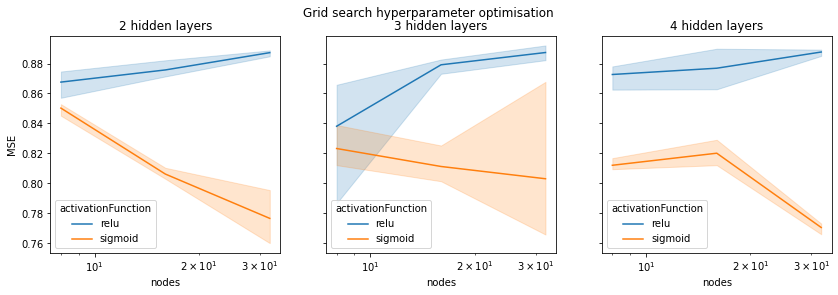

In [102]:
# fig, ax = plt.subplots(1, 3, figsize=(6,6))

# sns.lineplot(ax=ax,
#              data=structureResultsLong,
#              x='nodes',
#              y='MSE',
#              hue='layers',
#              style='activationFunction',
#              palette='tab10',
             
#              #y
#             )
# ax.legend()
# ax.set_xlabel('nodes')
# ax.set_ylabel('MSE')

# ax.set(xscale="log")#, yscale="log")
# plt.show()

# Create figure for grid search results
fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True)
# Plot results
for i, ax in enumerate(axs):

    numberLayers = structureResultsLong['layers'].unique()[i]

    sns.lineplot(ax=ax,
                data=structureResultsLong[structureResultsLong['layers'] == numberLayers],
                x='nodes',
                y='MSE',
                hue='activationFunction',
                palette='tab10',
                )    
    # Set log axis and title
    ax.set(xscale='log')
    ax.set_title(f'{numberLayers} hidden layers')
# Add title
fig.suptitle('Grid search hyperparameter optimisation', fontsize=12)
#fig.savefig('gridSearchResults', bbox_inches='tight')
plt.show()

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

#### Test Best Model

In [ ]:
best = newModel(4, 32, 'sigmoid')

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

historyBest = best.fit(X_trainLoss,
                    y_trainLoss,
                    validation_data=(X_validateLoss,
                                     y_validateLoss),
                    epochs=1000,
                    batch_size=64,
                    verbose=0,
                        callbacks=[es]
                   )

Epoch 00080: early stopping


(0.0, 0.5)

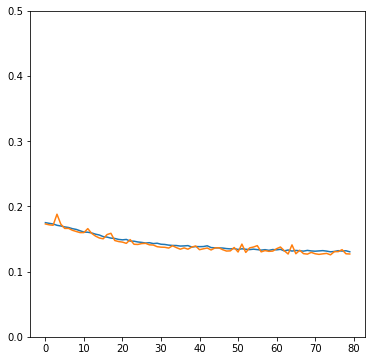

In [ ]:
fig, ax =plt.subplots(figsize=(6,6))

ax.plot(historyBest.history['loss'], label='train')
ax.plot(historyBest.history['val_loss'], label='validate')

ax.set_ylim([0, 0.5])

In [ ]:
bestPred = best.predict(X_test)

In [ ]:
bestPred

array([[-1.0926963 ],
       [-0.13992654],
       [ 0.14557756],
       ...,
       [-0.48154464],
       [-1.0562218 ],
       [-0.12411742]], dtype=float32)

In [ ]:
y_test

array([277000., 364500., 471000., ..., 345000., 305000., 450000.])

In [ ]:
bestPredPlot = invert(bestPred)
#yTestPlot = invert(y_)

bestPredPlot

array([260594.86, 430821.78, 500867.  , ..., 359761.16, 265658.88,
       434430.6 ], dtype=float32)

Text(0, 0.5, 'Prediction')

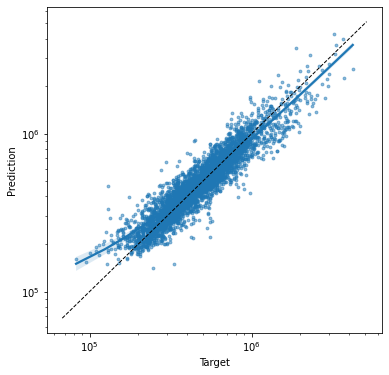

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

ax = sns.regplot(x=y_test,
                 y=bestPredPlot,
                 scatter_kws={'s':8,
                              'alpha':0.5},                
               )

ax.set(xscale="log", yscale="log")

xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1)#, scalex=False, scaley=False)

#ax = sns.lineplot(x=[0,1], y=[0,1])#, transform=ax.transAxes)

#ax.axis('equal')

ax.set_xlabel('Target')
ax.set_ylabel('Prediction')

In [ ]:
mean_squared_error(y_test, bestPredPlot, squared=False) 

138696.5957849268